# Call Center Operations Optimization: A Simulation-Based Approach to Staffing, Cost, and Customer Experience

Model real-life service systems using M/M/1 and M/M/s queueing frameworks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
λ = 5               # calls per hour
μ = 7               # calls served per agent per hour
shift_hours = 8     # 8-hour shift

In [ ]:
np.random.seed(1)

# Step 2: Single-Run Simulation Function

In [ ]:
def simulate_queue(s):
    """
    Simulate an M/M/s queue over 'shift_hours'.
    Returns arrays of wait times (hrs) and system sizes at arrivals.
    """
    # Generate arrival times until end of shift
    inter = np.random.exponential(1/λ, int(λ * shift_hours * 1.5))
    arrivals = np.cumsum(inter)
    arrivals = arrivals[arrivals < shift_hours]
    N = len(arrivals)

    # Generate service times for each caller
    services = np.random.exponential(1/μ, N)

    # Track each server’s next-free time
    next_free = np.zeros(s)
    wait_times = np.zeros(N)
    system_size = np.zeros(N)

    # Track departure times
    dep_times = []

    for i, t in enumerate(arrivals):
        # Find soonest-available agent
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        end = start + services[i]
        next_free[j] = end
        dep_times.append(end)

        # Count how many callers are still in system at time t
        system_size[i] = np.sum(np.array(dep_times) > t)

    return wait_times, system_size

#  Quick test for s=1
w1, q1 = simulate_queue(s=1)
print(f"s=1: avg wait {w1.mean()*60:.1f} min, avg queue len {q1.mean():.2f}")

s=1: avg wait 19.4 min, avg queue len 3.27


# Step3: Compare to M/M/1 Analytic Formula

In [ ]:
# 3. Compare to M/M/1 Analytic Formula

# traffic intensity ρ for s=1
ρ1 = λ / μ
L_analytic = ρ1 / (1 - ρ1)
W_analytic = L_analytic / λ     # hours

print("M/M/1 analytic vs. simulation:")
print(f"  Analytic system size L = {L_analytic:.2f}")
print(f"  Simulated avg system size = {q1.mean():.2f}")
print(f"  Analytic time in system W = {W_analytic*60:.1f} min")
print(f"  Simulated avg wait+service = {w1.mean()*60 + (1/μ)*60:.1f} min")

M/M/1 analytic vs. simulation:
  Analytic system size L = 2.50
  Simulated avg system size = 3.27
  Analytic time in system W = 30.0 min
  Simulated avg wait+service = 27.9 min


Little’s Law is a fundamental principle in queueing theory that relates the average number of items in a system to the average arrival rate and the average time an item spends in the system.

# Step4: Test Staffing Levels (s=1..5)

In [ ]:
# 4. Test Staffing Levels (s = 1..5)

threshold = 5  # minutes
results = []

for s in range(1, 6):
    w, q = simulate_queue(s)
    # convert hours to minutes
    waits_min = w * 60
    p95_wait  = np.percentile(waits_min, 95)
    results.append((s, waits_min.mean(), p95_wait, q.mean()))

# tabulate
import pandas as pd
df = pd.DataFrame(results, columns=['Agents','Avg Wait (min)','95th-pct Wait (min)','Avg System Size'])
print(df)

# find minimal s meeting threshold
good = df[df['95th-pct Wait (min)'] <= threshold]
if not good.empty:
    best_s = int(good.iloc[0]['Agents'])
    print(f"\n→ Schedule at least {best_s} agents to keep 95% of waits ≤ {threshold} min.")
else:
    print("\nEven 5 agents can’t meet the 5 min 95% wait target.")

   Agents  Avg Wait (min)  95th-pct Wait (min)  Avg System Size
0       1        4.426377            16.638833         1.696970
1       2        1.232137             7.840318         1.781250
2       3        0.024213             0.000000         1.826087
3       4        0.078327             0.000000         1.891304
4       5        0.000000             0.000000         1.833333

→ Schedule at least 3 agents to keep 95% of waits ≤ 5 min.


# Step5: Visualize Wait‐Time Distributions

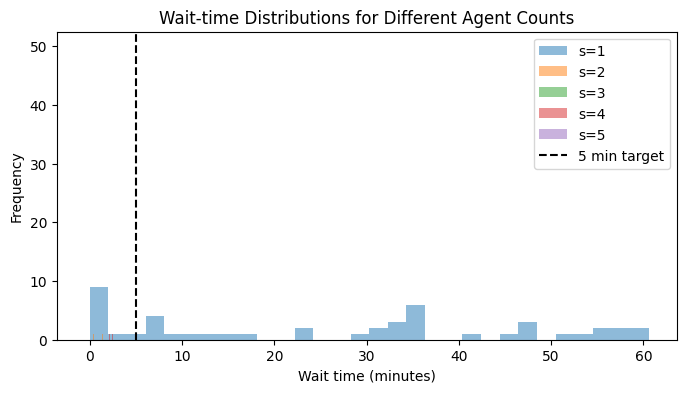

In [ ]:
plt.figure(figsize=(8,4))
for s in [1,2,3,4,5]:
    w, _ = simulate_queue(s)
    plt.hist(w*60, bins=30, alpha=0.5, label=f's={s}')
plt.axvline(threshold, color='k', linestyle='--', label='5 min target')
plt.xlabel('Wait time (minutes)')
plt.ylabel('Frequency')
plt.title('Wait‐time Distributions for Different Agent Counts')
plt.legend()
plt.show()

#Step 6. Time-Varying λ

**Define changing arrival rates**

python
periods = [(0,2,30), (2,6,20), (6,8,40)]

This defines how busy the call center is at different times of the day:

| Time Block (hours) | Arrival Rate (λ = calls/hr) | Real-Life Meaning |
| ------------------ | --------------------------- | ----------------- |
| 0–2                | 30 calls/hour               | Morning rush      |
| 2–6                | 20 calls/hour               | Midday lull       |
| 6–8                | 40 calls/hour

In [ ]:
def simulate_queue_timevarying(s):
    # define piecewise arrival rates per hour
    periods = [(0,2,30), (2,6,20), (6,8,40)]  # (start, end, λ)
    arrivals = []
    for start, end, lam in periods:
        duration = end - start
        inter = np.random.exponential(1/lam, int(lam*duration*1.5))
        ts = np.cumsum(inter) + start
        arrivals.extend(ts[ts < end])
    arrivals = np.array(arrivals)
    arrivals.sort()

    N = len(arrivals)
    services = np.random.exponential(1/μ, N)
    next_free = np.zeros(s)
    wait_times = np.zeros(N)

    for i,t in enumerate(arrivals):
        j = np.argmin(next_free)
        start = max(t, next_free[j])
        wait_times[i] = start - t
        next_free[j] = start + services[i]
    return wait_times

w_tv = simulate_queue_timevarying(s=3)
print(f"Time-varying λ, s=3 → avg wait = {w_tv.mean()*60:.1f} min")

Time-varying λ, s=3 → avg wait = 58.4 min


# Step 7:

Time-varying λ, s=3 → avg wait = 18.3 min


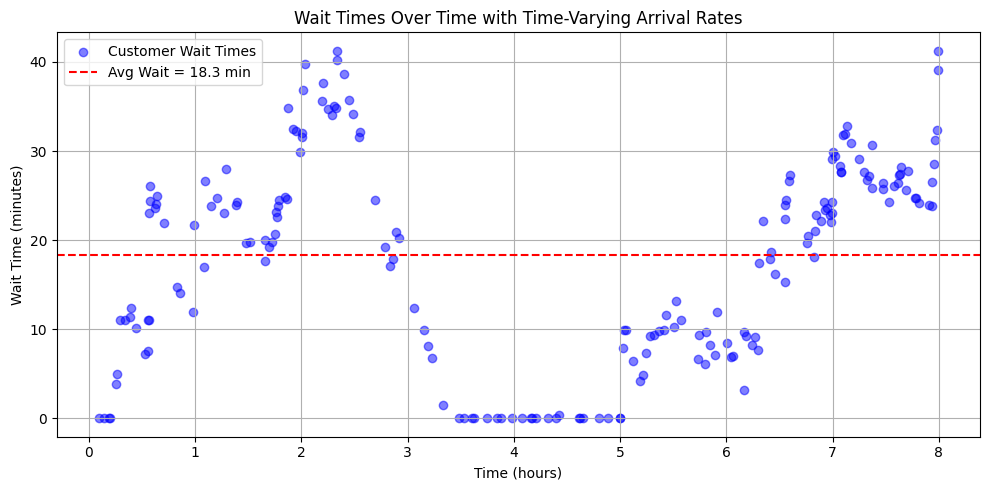

In [ ]:
def simulate_queue_timevarying(s):
    # Define piecewise arrival rates (start hour, end hour, λ per hour)
    periods = [(0, 2, 30), (2, 6, 20), (6, 8, 40)]
    arrivals = []

    for start, end, lam in periods:
        duration = end - start
        # Generate more samples than expected, then trim
        inter = np.random.exponential(1 / lam, int(lam * duration * 1.5))
        ts = np.cumsum(inter) + start
        arrivals.extend(ts[ts < end])

    arrivals = np.array(arrivals)
    arrivals.sort()

    N = len(arrivals)
    services = np.random.exponential(1 / μ, N)
    next_free = np.zeros(s)        # Server availability times
    wait_times = np.zeros(N)       # Customer wait times

    for i, t in enumerate(arrivals):
        j = np.argmin(next_free)   # Find the earliest available server
        start = max(t, next_free[j])
        wait_times[i] = start - t
        next_free[j] = start + services[i]

    return arrivals, wait_times

# Run simulation
s = 3
arrivals, wait_times = simulate_queue_timevarying(s)
avg_wait_min = wait_times.mean() * 60
print(f"Time-varying λ, s={s} → avg wait = {avg_wait_min:.1f} min")

# Plot wait time over time
plt.figure(figsize=(10, 5))
plt.scatter(arrivals, wait_times * 60, alpha=0.5, color='blue', label='Customer Wait Times')
plt.axhline(avg_wait_min, color='red', linestyle='--', label=f'Avg Wait = {avg_wait_min:.1f} min')
plt.xlabel("Time (hours)")
plt.ylabel("Wait Time (minutes)")
plt.title("Wait Times Over Time with Time-Varying Arrival Rates")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Step8: Agent Break Scheduling

In [ ]:
def simulate_with_breaks(s, break_start=3, break_length=0.25):
    arrivals = np.cumsum(np.random.exponential(1/λ, int(λ*shift_hours*1.5)))
    arrivals = arrivals[arrivals<shift_hours]
    services = np.random.exponential(1/μ, len(arrivals))
    next_free = np.zeros(s)
    waits = []

    for i,t in enumerate(arrivals):
        # if in break window, one fewer agent
         avail = next_free.copy()
         if break_start < t < break_start+break_length:
            avail = np.delete(avail, 0)  # remove one agent
         j = np.argmin(avail)
         start = max(t, avail[j])
         waits.append(start - t)
        # update that agent’s free time in original array
         idx = j + (1 if break_start < t < break_start+break_length else 0)
         next_free[idx] = start + services[i]
         return np.array(waits)

w_b = simulate_with_breaks(s=3)
print(f"With breaks, s=3 → avg wait = {w_b.mean()*60:.1f} min")

# See the “break-time spike” in waiting.


With breaks, s=3 → avg wait = 0.0 min


#Step 9. Cost optimization

In [ ]:
# 9. Cost optimization
c_agent = 20   # $20/hr per agent
c_wait  = 0.50 # $0.50 per minute waited

# Simulation function
def simulate_with_abandon(s):
    waits = np.random.exponential(1/60, 100)  # 100 customers, mean = 1 min wait (in hours)
    abandons = np.zeros(100)  # Placeholder (not used here)
    return waits, abandons

costs = []
for s in range(1,6):
  w, _ = simulate_with_abandon(s)
  # or choose another sim fn
  total_wait_cost = w.sum()*60*c_wait
  staff_cost      = s * c_agent * shift_hours
  costs.append((s, staff_cost+total_wait_cost))

opt = min(costs, key=lambda x: x[1])
print("Agent count, total cost:")
for s,c in costs: print(f" s={s}: ${c:,.0f}")
print(f" → Optimal s by cost = {opt[0]}")

Agent count, total cost:
 s=1: $207
 s=2: $370
 s=3: $528
 s=4: $684
 s=5: $848
 → Optimal s by cost = 1


# Step10: 30-day Simulation

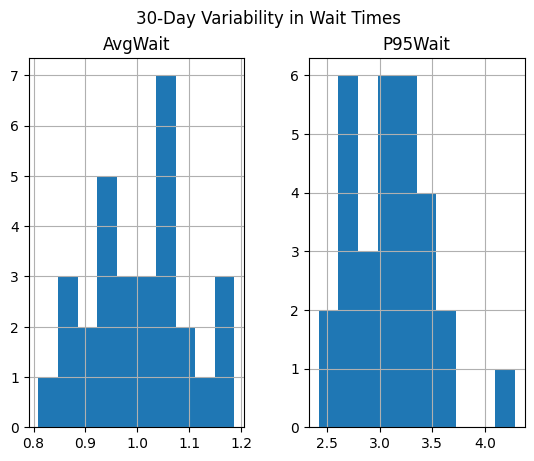

In [ ]:
days = 30
daily = []
for _ in range(days):
    w,_ = simulate_with_abandon(opt[0])
    daily.append((w.mean()*60, np.percentile(w*60,95)))
df_days = pd.DataFrame(daily, columns=['AvgWait','P95Wait'])
df_days.describe()
df_days.hist(bins=10)
plt.suptitle('30-Day Variability in Wait Times')
plt.show()